Let's start here! If you can directly link to an image relevant to your notebook, such as [canonical logos](https://github.com/numpy/numpy/blob/main/doc/source/_static/numpylogo.svg), do so here at the top of your notebook. You can do this with Markdown syntax,

> `![<image title>](http://link.com/to/image.png "image alt text")`

or edit this cell to see raw HTML `img` demonstration. This is preferred if you need to shrink your embedded image. **Either way be sure to include `alt` text for any embedded images to make your content more accessible.**

<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img>

# Understanding extreme weather variability in the Caribbean region

---

## Overview
Extreme weather events, both atmospheric and oceanic, are increasing in frequency and intensity as a consequence of anthropogenic warming. The processes responsible for such events and their impacts on Caribbean lives remain to be well understood. Our Caribbeans for Climate community (a community of Caribbean-identified climate scientists, oceanographers, and practitioners) have created a cookbook analyzing Caribbean atmospheric and oceanic extreme weather variability from 1850-2015, using Coupled Model Intercomparison Project Phase 6 (CMIP6) data. In this notebook, we execute basic statistical analysis to investigate the linkages between extreme atmospheric and oceanic heat-related events and the possible causes behind them.


1. Locate times when sea surface temperatures exceeded the 90th percentile threshold 
1. Timeseries of ENSO 3.4 index
1. Locate times of hurricanes 
1. Run basic statistics to determine any correlation between the aforementioned metrics

## Prerequisites
Some relavent knowledge on how to use certain packages (e.g. `xarray`, `matplotlib`) would be helpful to you in understanding this tutorial. If you need a refresher on how to employ these packages please refer to the [Pythia Foundations](https://foundations.projectpythia.org/landing-page.html) page. Also, please refer to the Project Pythia's [CMIP6 cookbook](https://projectpythia.org/cmip6-cookbook/README.html) page to familiarize yourself on how to ingest CMIP6 data.


| Concepts | Importance | Notes |
| --- | --- | --- |
| [CMIP6 data structure](https://projectpythia.org/cmip6-cookbook/README.html) | Necessary | Familiarity with query techniques|
| [Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necessary | Familiarity with manipulating data structure|
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Helpful|
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Pip install `regionmask` and `xmip` packages into current environment

In [105]:
!pip install git+https://github.com/mathause/regionmask.git

  Cloning https://github.com/mathause/regionmask.git to /tmp/pip-req-build-gqsy3j0z
  Running command git clone --filter=blob:none --quiet https://github.com/mathause/regionmask.git /tmp/pip-req-build-gqsy3j0z
  Resolved https://github.com/mathause/regionmask.git to commit 8fa448e1ae9131ecb028b52ce3740d3627d8fe75
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for regionmask: filename=regionmask-0.9.0.post1.dev95+g8fa448e-py3-none-any.whl size=68020 sha256=daae25d65a3ac69dc10f133db56ad1adcf5d4f3ca162669ac27c4d1ba4953e83
  Stored in directory: /tmp/pip-ephem-wheel-cache-dpx3pjda/wheels/12/3c/e1/f1c2864aa8015b011d0c6dca10f004441dd966f8b80b6e0583
Successfully built regionmask


In [106]:
!pip install git+https://github.com/jbusecke/xmip.git

  Cloning https://github.com/jbusecke/xmip.git to /tmp/pip-req-build-idij7h4p
  Running command git clone --filter=blob:none --quiet https://github.com/jbusecke/xmip.git /tmp/pip-req-build-idij7h4p
  Resolved https://github.com/jbusecke/xmip.git to commit aff665950556abc1bdbae521c308a86f9ef8899a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 751.8 kB/s eta 0:00:000:00:01
  Created wheel for xmip: filename=xmip-0.7.3.dev20+gaff6659-py3-none-any.whl size=58791 sha256=26c09a2a4244cfde588dff443c28bb37dbb6ff5aca7bcb1e3863f13947c28762
  Stored in directory: /tmp/pip-ephem-wheel-cache-ieljxqxd/wheels/cc/cb/e0/c0e3e2261ea5177d2f86070a483c40d9c878e6dd2e14a7f824
Successfully built xmip
  Attempting uninstall: xgcm
    Found existing installation: xgcm 0.8.1
    Uninstalling xgcm-0.8.1:
      Successfully uninstalled xgcm-0.8.1
  Attempting uninstall: xm

## Imports

In [13]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import nc_time_axis
import regionmask  
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6

## Extreme SSTs

Marine heatwaves (MHWs) are characterized by extremely warm ocean temperatures that can span thousands of kilometers and last from days to months (Holbrook et al., 2019). Generally, they are defined as a MHW event when sea surface temperature (SST) exceed a certain threshold (typically, the 90th percentile threshold), and lasts for ≥5 consecutive days. These events can be devastating to marine life and the people that depend on maritime regions for sustenance and economy; such as fisheries and tribal communities. Despite their societal importance, however, a comprehensive understanding of the physical mechanisms driving MHWs in current and future climates does not yet exist. 

In this section, we will look at SST data from 2000-present and identify times when SST anomalies are within the 99th percentile and last for ≥10 days. These will be marked as extreme MHW events and help us better identify any potential correlative relationship between extreme SSTs and hurricane incidences. 

> Holbrook, Neil J., Hillary A. Scannell, Alexander Sen Gupta, Jessica A. Benthuysen, Ming Feng, Eric C. J. Oliver, Lisa V. Alexander, et al. “A Global Assessment of Marine Heatwaves and Their Drivers.” Nature Communications 10, no. 1 (June 14, 2019): 2624. https://doi.org/10.1038/s41467-019-10206-z.

A data request can be made with 3 keywords: 'experiment_id', 'table_id', and 'variable_id'.
`experiment_id = 'historical'`, `table_id='Oday'`, `variable_id=''`

List of potential variable names:
- `thetaoga = Global Average Sea Water Potential Temperature [degC]`
- `thetao = Sea Water Potential Temperature [degC]`
- `tosga = Global Average Sea Surface Temperature [degC]`
- `tos = Sea Surface Temperature [degC]`

### Load in the data

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [4]:
np.unique(df['activity_id'])

array(['AerChemMIP', 'C4MIP', 'CDRMIP', 'CFMIP', 'CMIP', 'DAMIP', 'DCPP',
       'FAFMIP', 'GMMIP', 'HighResMIP', 'ISMIP6', 'LS3MIP', 'LUMIP',
       'OMIP', 'PAMIP', 'PMIP', 'RFMIP', 'ScenarioMIP'], dtype=object)

In [5]:
df_tos = df.query("table_id == 'Oday' & variable_id == 'tos' & experiment_id == 'historical'" + 
                  "& institution_id == 'NOAA-GFDL'")
df_tos

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9445,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Oday,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
9446,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
244828,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726
244829,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Oday,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726


In [6]:
np.unique(df_tos['activity_id'])

array(['CMIP'], dtype=object)

In [3]:
df_tos = df.query("table_id == 'Oday' & variable_id == 'tos' & experiment_id == 'historical'" + 
                  "& institution_id == 'NOAA-GFDL' & source_id == 'GFDL-CM4'")
df_tos

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9445,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Oday,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
9446,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701


In [4]:
np.unique(df_tos['zstore'])

array(['gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Oday/tos/gn/v20180701/',
       'gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Oday/tos/gr/v20180701/'],
      dtype=object)

In [5]:
# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_tos['zstore'].values[-1]
print(zstore)

# create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Oday/tos/gn/v20180701/


<xarray.Dataset> Size: 375GB
Dimensions:    (bnds: 2, y: 1080, x: 1440, vertex: 4, time: 60225)
Coordinates:
  * bnds       (bnds) float64 16B 1.0 2.0
    lat        (y, x) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lat_bnds   (y, x, vertex) float32 25MB dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lon        (y, x) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon_bnds   (y, x, vertex) float32 25MB dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bnds  (time, bnds) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
  * x          (x) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * y          (y) float64 9kB -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Dimensions without coordinates: vertex
Data variables:
    tos        (time, y, x) float32 375GB dask.array<chunksize=(18, 1080, 1440), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tos
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-11-16;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/e3b86300-29b2-4220-97ce-40fa504858e5...
    version_id:             v20180701

In [6]:
ds.tos

<xarray.DataArray 'tos' (time: 60225, y: 1080, x: 1440)> Size: 375GB
dask.array<open_dataset-tos, shape=(60225, 1080, 1440), dtype=float32, chunksize=(18, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon      (y, x) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * time     (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 12kB -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y        (y) float64 9kB -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

### Define the Caribbean Sea & Gulf of Mexico regions

<GeoAxes: >

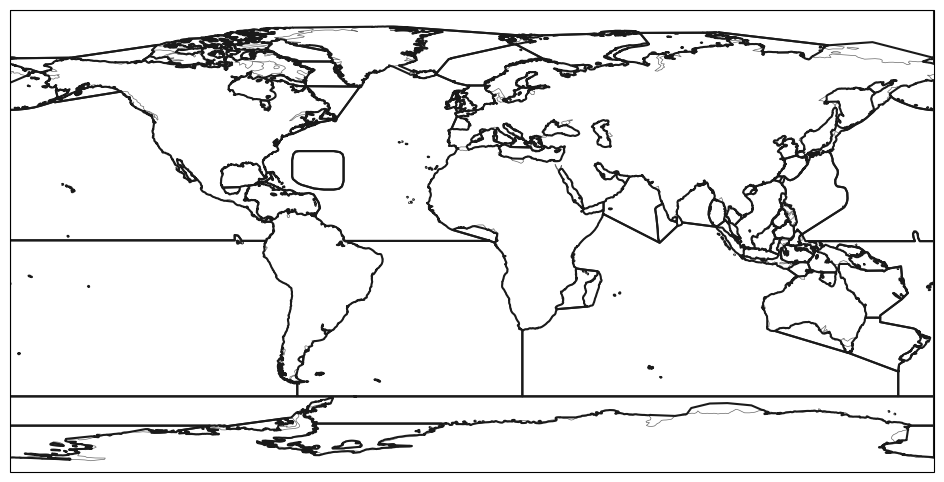

In [8]:
# load ocean basin data
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50
basins.plot(add_ocean=False, add_label=False)

In [10]:
da = ds.tos.isel(time=0).load()
mask = merged_mask(basins, da)

/srv/conda/envs/notebook/lib/python3.11/site-packages/regionmask/core/mask.py:178: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


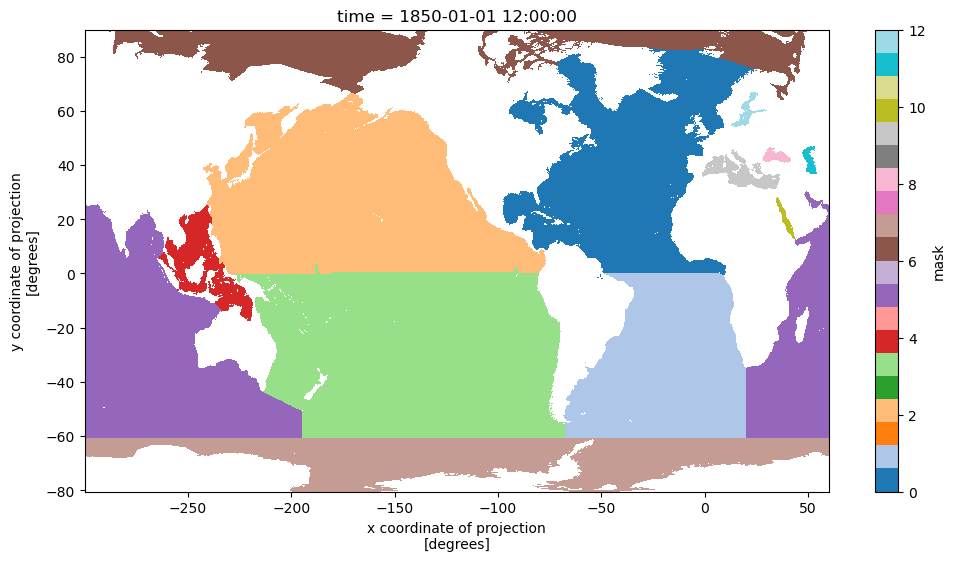

In [12]:
mask.plot(cmap='tab20')

In [17]:
natl = 0
sst = ds.tos.where(mask==natl)
carib = dict(x=slice(-98, -55), y=slice(8, 31))
csst = sst.sel(**carib)

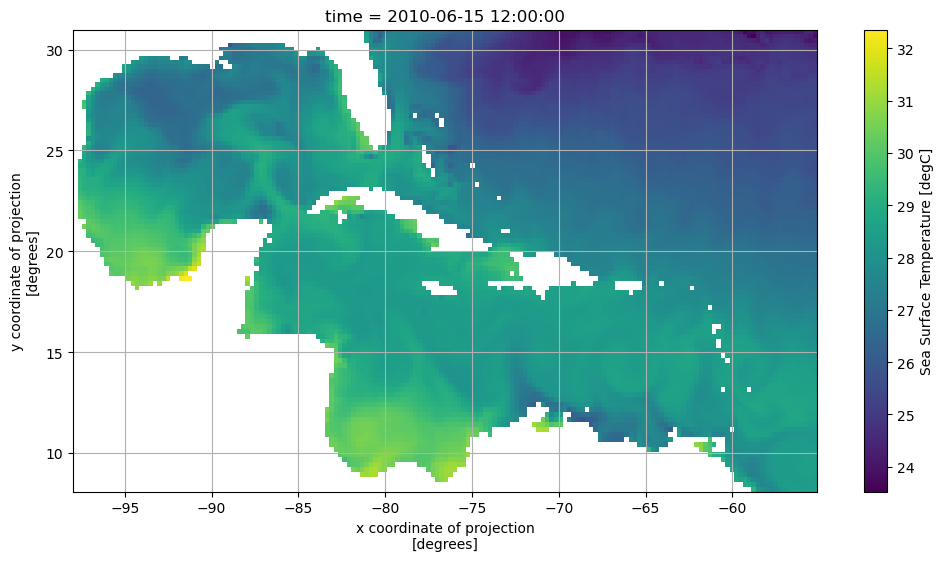

In [19]:
csst.sel(time='2010-06-15').squeeze().plot()
plt.grid();

### Another content subsection
Keep up the good work! A note, *try to avoid using code comments as narrative*, and instead let them only exist as brief clarifications where necessary.

## Hurricanes
Here we can move on to our second objective, and we can demonstrate

### Subsection to the second section

#### a quick demonstration

##### of further and further

###### header levels

as well $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax (demo below from link),

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**Jupyter docs**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) for Jupyter-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## El Niño 3.4 idnex

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!